In [82]:
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from datetime import datetime,timedelta
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [84]:
df= pd.read_csv("/datasets/Retail_Data_Transactions.csv")
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [85]:
df.dtypes

customer_id    object
trans_date     object
tran_amount     int64
dtype: object

In [86]:
df.shape

(125000, 3)

In [87]:
df['trans_date']=pd.to_datetime(df['trans_date'])

In [88]:
df.dtypes

customer_id            object
trans_date     datetime64[ns]
tran_amount             int64
dtype: object

In [89]:
#no missing values
df.isna().sum()/len(df)

customer_id    0.0
trans_date     0.0
tran_amount    0.0
dtype: float64

In [90]:
#number of unique customer id
df['customer_id'].nunique()

6889

In [91]:
#dataset has 5 years of data
df['trans_date'].min(),df['trans_date'].max()

(Timestamp('2011-05-16 00:00:00'), Timestamp('2015-03-16 00:00:00'))

<AxesSubplot:>

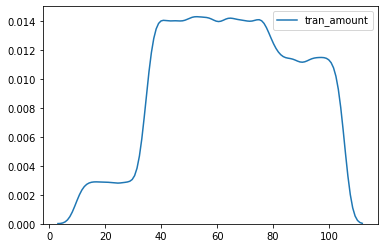

In [92]:
sns.kdeplot(df['tran_amount'])

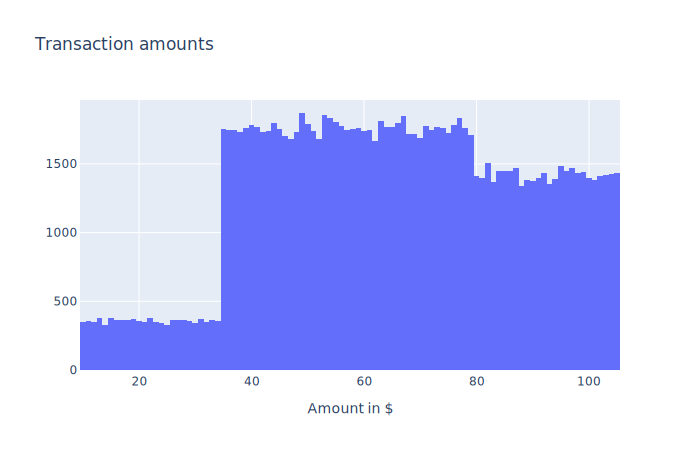

In [95]:
#plot the histogram

#most transactions are in $40-$80 range
plot_data = [
    go.Histogram(
        x=df['tran_amount']
    )
]

plot_layout = go.Layout(
        title='Transaction amounts',
        xaxis_title="Amount in $",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig)
fig.show("svg")

### RFM

Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.

Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.

High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

#### Recency

In [96]:
df_user=pd.DataFrame(df['customer_id'].unique())
df_user.columns=['customer_id']

In [97]:
df_max_purchase=df.groupby('customer_id')['trans_date'].max().reset_index()
df_max_purchase

,customer_id,trans_date
0,CS1112,2015-01-14
1,CS1113,2015-02-09
2,CS1114,2015-02-12
3,CS1115,2015-03-05
4,CS1116,2014-08-25
...,...,...
6884,CS8996,2014-12-09
6885,CS8997,2014-06-28
6886,CS8998,2014-12-22
6887,CS8999,2014-07-02


In [98]:
df_max_purchase.rename(columns={'trans_date':'max_trans_date'},inplace=True)

In [99]:
df_max_purchase['Recency'] = (df_max_purchase['max_trans_date'].max() - df_max_purchase['max_trans_date']).dt.days
df_max_purchase.head()

,customer_id,max_trans_date,Recency
0,CS1112,2015-01-14,61
1,CS1113,2015-02-09,35
2,CS1114,2015-02-12,32
3,CS1115,2015-03-05,11
4,CS1116,2014-08-25,203


In [100]:
df_user=pd.merge(df_user,df_max_purchase[['customer_id','Recency']],on='customer_id')
df_user.head()

,customer_id,Recency
0,CS5295,111
1,CS4768,1
2,CS2122,21
3,CS1217,77
4,CS1850,7


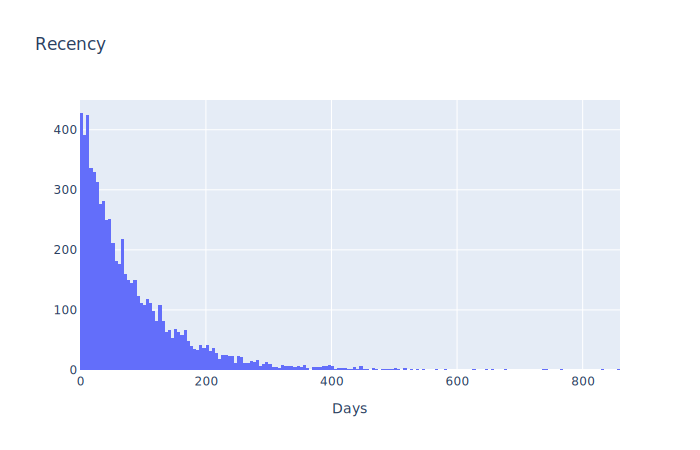

In [101]:
#a lot of transactions between 0 and 14 days from the max date in the dataset
plot_data = [
    go.Histogram(
        x=df_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency',
        xaxis_title="Days",
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig)
fig.show("svg")

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

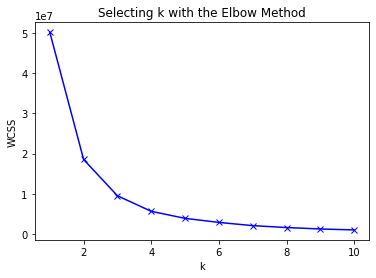

In [102]:
#running KMeans to assign recency score to each customer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

wcss = []
df_recency=df_user[['Recency']]
for k in range(1,11):
    kmeans=KMeans(n_clusters=k, init="k-means++", random_state =42,n_init=10,max_iter=300) 
    kmeans.fit(df_recency)
    wcss.append(kmeans.inertia_) 
plt.plot(range(1,11), wcss, 'bx-')

plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Selecting k with the Elbow Method')

In [103]:
kmeans=KMeans(n_clusters=3, init="k-means++", random_state =42,n_init=10,max_iter=300) 
kmeans.fit(df_user[['Recency']])

KMeans(n_clusters=3, random_state=42)

In [104]:
print(silhouette_score(df_user[['Recency']], kmeans.labels_))

0.6337594740427278


In [105]:
df_user['RecencyCluster']=kmeans.predict(df_user[['Recency']])

In [106]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_max_purchase = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [107]:
#cluster 0 is our best customers in terms of recency. Good news: there are many of them
df_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,4625.0,35.091676,24.713502,0.0,13.00,31.0,54.00,87.0
1,1874.0,140.644610,39.129239,88.0,108.00,131.0,168.00,235.0
2,390.0,330.669231,98.830206,236.0,258.25,295.5,380.25,857.0


<AxesSubplot:xlabel='RecencyCluster', ylabel='Recency'>

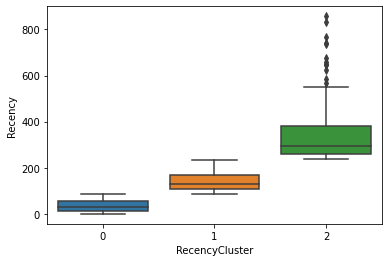

In [108]:
sns.boxplot(df_user['RecencyCluster'],df_user['Recency'])

### Frequency

In [109]:
df_freq=df.groupby('customer_id')['trans_date'].count().reset_index()

In [110]:
df_freq.rename(columns={'trans_date':'Frequency'},inplace=True)

In [111]:
df_user=pd.merge(df_user,df_freq,on='customer_id')
df_user.head()

,customer_id,Recency,RecencyCluster,Frequency
0,CS5295,111,1,25
1,CS4768,1,0,26
2,CS2122,21,0,23
3,CS1217,77,0,20
4,CS1850,7,0,24


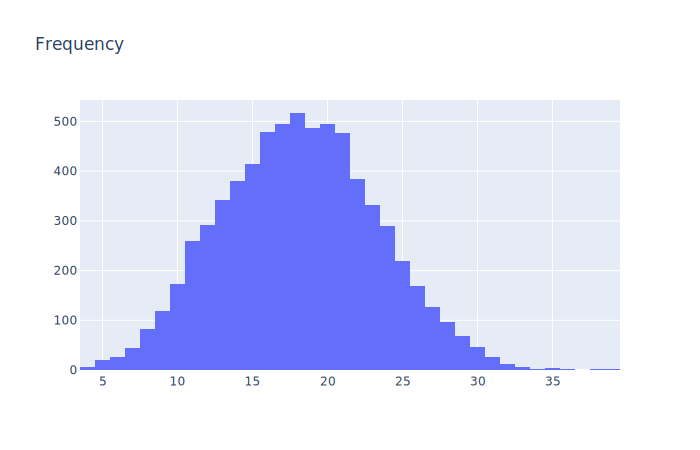

In [112]:
#no large frequency values:customers didn't buy many items over those 5 years
plot_data = [
    go.Histogram(
        x=df_user['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig)
fig.show("svg")

In [113]:
kmeans=KMeans(n_clusters=3, init="k-means++", random_state =42,n_init=10,max_iter=300) 
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster']=kmeans.predict(df_user[['Frequency']])

#order the frequency cluster
df_user=order_cluster('FrequencyCluster','Frequency',df_user,True)

In [114]:
#even though the dataset has over 6K customers, they didn't make a lot of purchases and it's the non-recent customers who made
#more purchases. 
#Maybe look at what has changed that they don't come back any more (quality of product,availability of product etc.?)
df_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2157.0,12.224386,2.383014,4.0,11.0,13.0,14.0,15.0
1,2947.0,18.492365,1.693261,16.0,17.0,18.0,20.0,21.0
2,1785.0,24.725490,2.571782,22.0,23.0,24.0,26.0,39.0


<AxesSubplot:xlabel='FrequencyCluster', ylabel='Frequency'>

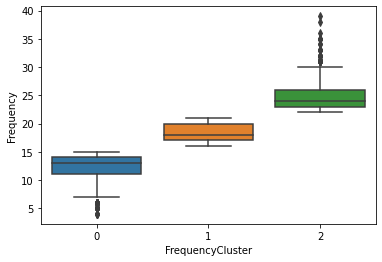

In [115]:
sns.boxplot(df_user['FrequencyCluster'],df_user['Frequency'])

### Revenue

In [116]:
df_revenue=df.groupby('customer_id')['tran_amount'].sum().reset_index()

In [117]:
df_revenue.rename(columns={'tran_amount':'Revenue'},inplace=True)

In [118]:
df_user=pd.merge(df_user,df_revenue,on='customer_id')

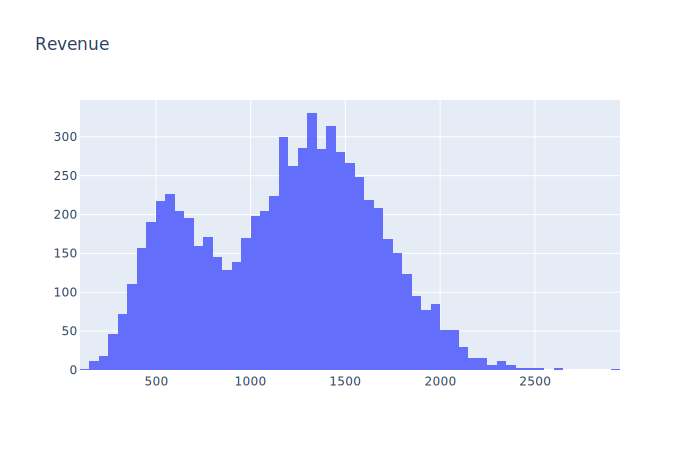

In [119]:
#there is 2 groups of customers based on revenue: avg spending around $500 and around $1300
plot_data = [
    go.Histogram(
        x=df_user['Revenue']
    )
]

plot_layout = go.Layout(
        title='Revenue',
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig)
fig.show("svg")

customers in 500 revenue group didn't purchase many items and they aren't recent.

customers in 1300 revenue group had more items purchased and they are more recent. We should concentrate on them to increase their frequency

In [120]:
df_user.query("Revenue>500 and Revenue<600")[['Frequency']].median()

Frequency    12.0
dtype: float64

In [121]:
df_user.query("Revenue>500 and Revenue<600")[['Recency']].median()

Recency    76.0
dtype: float64

In [122]:
df_user.query("Revenue>1300 and Revenue<1400")[['Frequency']].median()

Frequency    19.0
dtype: float64

In [123]:
df_user.query("Revenue>1300 and Revenue<1400")[['Recency']].median()

Recency    51.0
dtype: float64

In [43]:
#df_user.loc[(df_user['Revenue']>500) & (df_user['Revenue']<600),['Frequency']].median()

In [124]:
kmeans=KMeans(n_clusters=3, init="k-means++", random_state =42,n_init=10,max_iter=300) 
kmeans.fit(df_user[['Revenue']])
df_user['RevenueCluster']=kmeans.predict(df_user[['Revenue']])

#order the frequency cluster
df_user=order_cluster('RevenueCluster','Revenue',df_user,True)

In [125]:
#cluster 2 brings the most revenue
df_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2092.0,601.118547,168.227350,149.0,477.0,598.0,736.0,913.0
1,2810.0,1225.867972,153.209801,914.0,1103.0,1239.0,1354.0,1472.0
2,1987.0,1722.073478,199.156086,1473.0,1564.0,1676.0,1829.5,2933.0


<AxesSubplot:xlabel='RevenueCluster', ylabel='Revenue'>

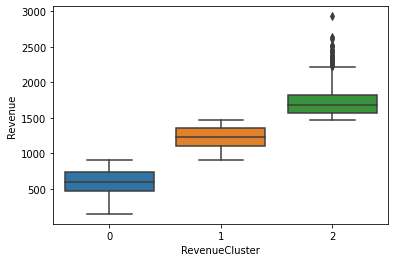

In [126]:
sns.boxplot(df_user['RevenueCluster'],df_user['Revenue'])

In [127]:
df_user['Score']=df_user['RecencyCluster']+df_user['FrequencyCluster']+df_user['RecencyCluster']

Our most desirable group is with score 1 because they are recent, bought the same amount as everyone and generated us decent revenue so we want to encourage them to come back.

A lot of missing opportunity to generate revenue on customers with score 3-6 because they bring high revenue but their recency is the problem. They buy on average around the same amount of items as most recent customers but could bring more revenue if we increase their recency through some marketing actions.

Frequency seem to be the problem regardless of the score but it would also depend on the nature of the business to see if it's
possible to increase the amount of purchases.

In [128]:
df_user.groupby('Score')['Recency','Frequency','Revenue'].mean()

<ipython-input-128-b895520bac12>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Revenue
Score,,,
0,37.055319,12.495319,684.723404
1,35.625555,18.570301,1230.195856
2,70.795794,20.559346,1374.937383
3,138.868712,18.406135,1214.801227
4,226.345964,18.690280,1217.571664
5,298.885714,17.657143,1152.771429
6,280.950000,23.950000,1664.800000


In [129]:
import pandasql as ps

q1 = """SELECT a.*,  
        CASE WHEN Score in (1,3,4,5) THEN 'Mid' 
                 WHEN Score in (2,6) THEN 'High' 
                 ELSE 'Low' END as Segment
from df_user a"""

df_user= ps.sqldf(q1, locals())

In [130]:
df_user.head()

,customer_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,Score,Segment
0,CS5295,111,1,25,2,1637,2,4,Mid
1,CS4768,1,0,26,2,1721,2,2,High
2,CS2122,21,0,23,2,1648,2,2,High
3,CS1850,7,0,24,2,1908,2,2,High
4,CS3802,26,0,25,2,1794,2,2,High


<AxesSubplot:xlabel='Recency', ylabel='Revenue'>

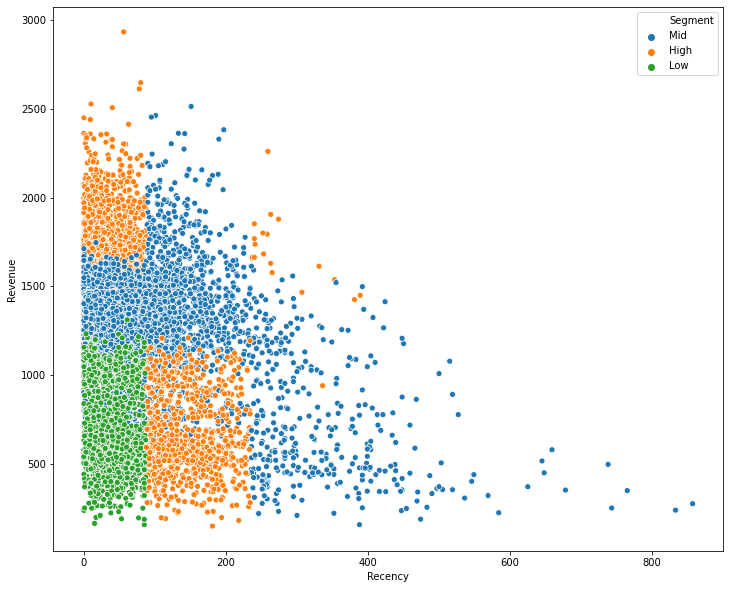

In [131]:
plt.figure(figsize=(12,10))
sns.scatterplot(x='Recency',y='Revenue',hue='Segment',data=df_user)

<AxesSubplot:xlabel='Frequency', ylabel='Revenue'>

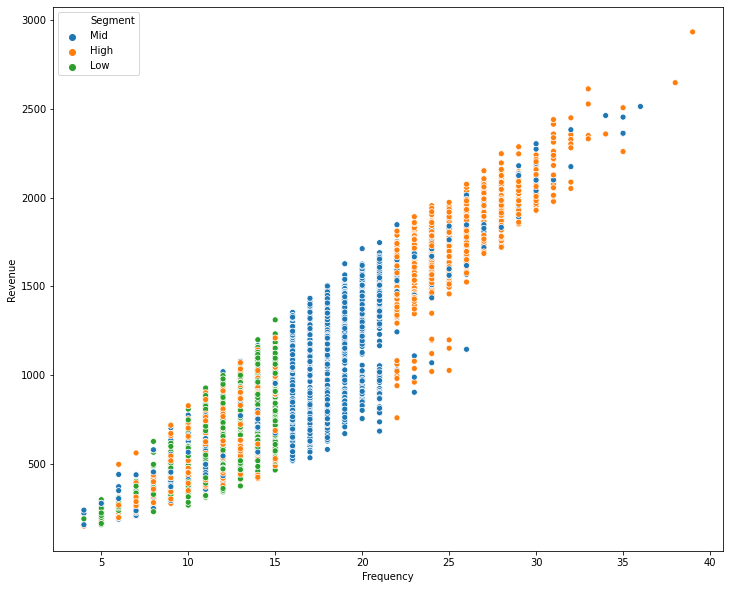

In [132]:
plt.figure(figsize=(12,10))
sns.scatterplot(x='Frequency',y='Revenue',hue='Segment',data=df_user)

<AxesSubplot:xlabel='Frequency', ylabel='Recency'>

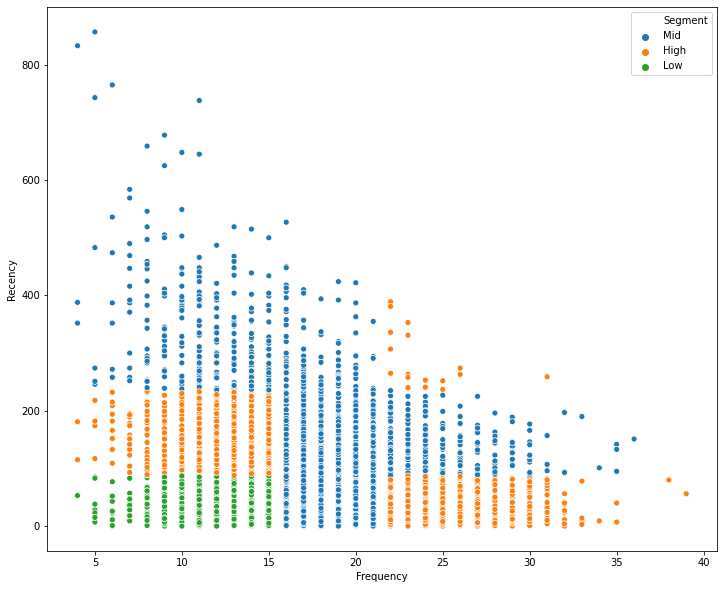

In [133]:
plt.figure(figsize=(12,10))
sns.scatterplot(x='Frequency',y='Recency',hue='Segment',data=df_user)

In [134]:
df['TransYearMonth']=df['trans_date'].map(lambda date:100*date.year + date.month)

In [135]:
df_revenue_=df.groupby('TransYearMonth')['tran_amount'].sum().reset_index()
df_revenue_.columns=['TransYearMonth','Revenue']

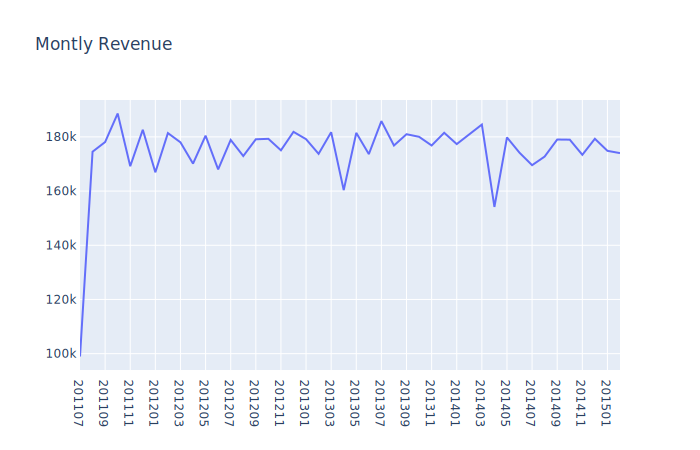

In [136]:
#revenue ranges within 15-20K range mostly but there are deeps in April 2013,2014 and we don't have data for April 2015 to 
#see if this pattern repeats. But since 2 years had a decrease, we might want to look into those months and see what's happening.
plot_data = [
    go.Scatter(
        x=df_revenue_.query('TransYearMonth>201106 and TransYearMonth<201503')['TransYearMonth'],
        y=df_revenue_['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig)
fig.show("svg")

In [137]:
df_revenue_['MonthlyGrowth']=df_revenue_['Revenue'].pct_change()
df_revenue_

,TransYearMonth,Revenue,MonthlyGrowth
0,201105,98951,NaN
1,201106,174527,0.763772
2,201107,178097,0.020455
3,201108,188631,0.059148
4,201109,169173,-0.103154
5,201110,182634,0.079569
6,201111,166921,-0.086035
7,201112,181405,0.086772
8,201201,177987,-0.018842
9,201202,170135,-0.044116


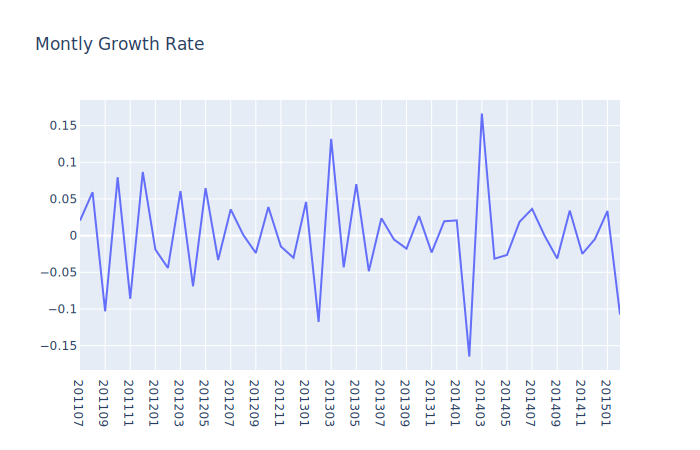

In [138]:
plot_data = [
    go.Scatter(
        x=df_revenue_.query("TransYearMonth < 201503 and TransYearMonth>201106")['TransYearMonth'],
        y=df_revenue_.query("TransYearMonth < 201503 and TransYearMonth>201106")['MonthlyGrowth'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Growth Rate'
    )

fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig)
fig.show("svg")

## New customer ratio

In [139]:
df.head()

,customer_id,trans_date,tran_amount,TransYearMonth
0,CS5295,2013-02-11,35,201302
1,CS4768,2015-03-15,39,201503
2,CS2122,2013-02-26,52,201302
3,CS1217,2011-11-16,99,201111
4,CS1850,2013-11-20,78,201311


In [140]:
df_min_=df.groupby('customer_id')['trans_date'].min().reset_index()

In [141]:
df_min_.rename(columns={'trans_date':'minpurchase_date'},inplace=True)

In [142]:
df_min_['minpurchase_date']=df_min_['minpurchase_date'].map(lambda date:100*date.year + date.month)

In [143]:
df=pd.merge(df,df_min_,on='customer_id')

In [144]:
df.head()

,customer_id,trans_date,tran_amount,TransYearMonth,minpurchase_date
0,CS5295,2013-02-11,35,201302,201110
1,CS5295,2014-11-25,54,201411,201110
2,CS5295,2013-05-22,37,201305,201110
3,CS5295,2012-12-24,36,201212,201110
4,CS5295,2013-03-22,98,201303,201110


In [145]:
df['UserType']='New'
df.loc[df['TransYearMonth']>df['minpurchase_date'],'UserType']='Existing'

In [146]:
df.head()

,customer_id,trans_date,tran_amount,TransYearMonth,minpurchase_date,UserType
0,CS5295,2013-02-11,35,201302,201110,Existing
1,CS5295,2014-11-25,54,201411,201110,Existing
2,CS5295,2013-05-22,37,201305,201110,Existing
3,CS5295,2012-12-24,36,201212,201110,Existing
4,CS5295,2013-03-22,98,201303,201110,Existing


In [147]:
df_user_type_revenue=df.groupby(['TransYearMonth','UserType'])['tran_amount'].sum().reset_index()
df_user_type_revenue.head()

,TransYearMonth,UserType,tran_amount
0,201105,New,98951
1,201106,Existing,34714
2,201106,New,139813
3,201107,Existing,84571
4,201107,New,93526


In [148]:
#new users don't generate much revenue at all
df_user_type_revenue.groupby('UserType')['tran_amount'].sum().reset_index()

,UserType,tran_amount
0,Existing,7606562
1,New,517427


In [149]:
#there aren't many new customers in this dataset
df.groupby('UserType')['customer_id'].count()

UserType
Existing    116829
New           8171
Name: customer_id, dtype: int64

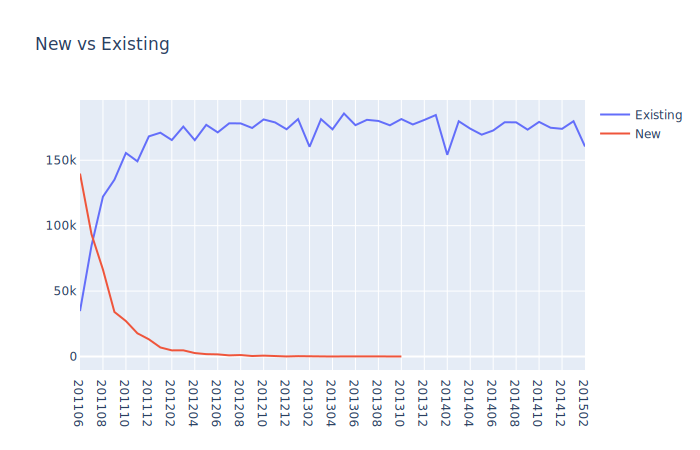

In [150]:
#new customers steadily don't generate any increase or any significant revenue at all
#Hence, the goal would be to retain existing customers
df_user_type_revenue = df_user_type_revenue.query("TransYearMonth != 201105 and TransYearMonth != 201503")
plot_data = [
    go.Scatter(
        x=df_user_type_revenue.query("UserType == 'Existing'")['TransYearMonth'],
        y=df_user_type_revenue.query("UserType == 'Existing'")['tran_amount'],
        name = 'Existing'
    ),
    go.Scatter(
        x=df_user_type_revenue.query("UserType == 'New'")['TransYearMonth'],
        y=df_user_type_revenue.query("UserType == 'New'")['tran_amount'],
        name = 'New'
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New vs Existing'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig) 
fig.show("svg")

In [151]:
#double checking the numbers with the plot
df[(df['TransYearMonth']==201301) & (df['UserType']=='Existing')]['tran_amount'].sum()

181458

In [152]:
df_user_ratio=df.query("UserType=='New'").groupby(['TransYearMonth'])['customer_id'].nunique()/df.query("UserType=='Existing'").groupby(['TransYearMonth'])['customer_id'].nunique()
df_user_ratio=df_user_ratio.reset_index()
df_user_ratio=df_user_ratio.dropna()
df_user_ratio

,TransYearMonth,customer_id
1,201106,4.234742
2,201107,1.168269
3,201108,0.568137
4,201109,0.273740
5,201110,0.195967
6,201111,0.129067
7,201112,0.088124
8,201201,0.049097
9,201202,0.034123
10,201203,0.027422


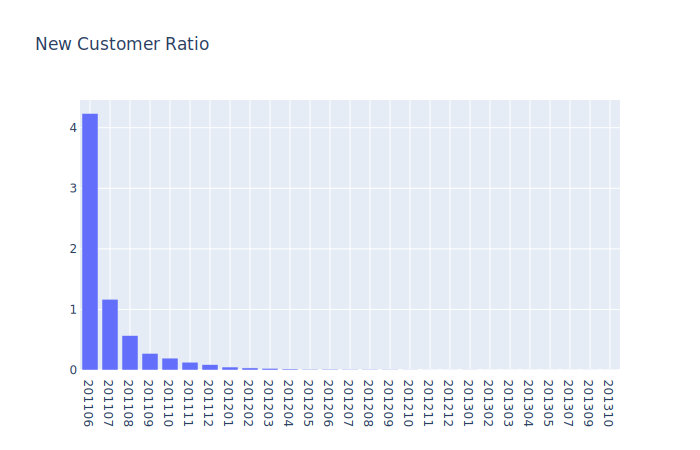

In [153]:
#there is close to zero acquisition of new customers after 2012
plot_data = [
    go.Bar(
        x=df_user_ratio.query("TransYearMonth != 201105 and TransYearMonth != 201503")['TransYearMonth'],
        y=df_user_ratio.query("TransYearMonth != 201105 and TransYearMonth != 201503")['customer_id'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='New Customer Ratio'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig) 
fig.show("svg")

### Monthly retention rate

In [154]:
df_purchase=df.groupby(['customer_id','TransYearMonth'])['tran_amount'].sum().reset_index()
df_purchase.head()

,customer_id,TransYearMonth,tran_amount
0,CS1112,201106,56
1,CS1112,201108,96
2,CS1112,201110,60
3,CS1112,201204,56
4,CS1112,201206,52


In [155]:
#1 if customer was active that month, 0 if not
df_retention=pd.crosstab(df_purchase['customer_id'],df_purchase['TransYearMonth']).reset_index()
df_retention.head()

TransYearMonth,customer_id,201105,201106,201107,201108,201109,201110,201111,201112,201201,...,201406,201407,201408,201409,201410,201411,201412,201501,201502,201503
0,CS1112,0,1,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,1,0,0
1,CS1113,1,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,1,0
2,CS1114,0,0,1,1,1,0,0,0,0,...,0,0,1,1,0,0,1,0,1,0
3,CS1115,0,0,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
4,CS1116,0,1,1,1,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [156]:
months=df_retention.columns[2:]

retention=[]

for i in range(len(months)-1):
    retention_data={}
    selected_month=months[i+1]
    prev_month=months[i]
    retention_data['TransYearMonth']=int(selected_month)
    retention_data['TotalUserCount']=df_retention[selected_month].sum()
    retention_data['RetainedUserCount']=df_retention[(df_retention[selected_month]>0) & df_retention[prev_month]>0][selected_month].sum()
    retention.append(retention_data)

In [157]:
df_retention=pd.DataFrame(retention)
df_retention['RetentionRate']=df_retention['RetainedUserCount']/df_retention['TotalUserCount']

In [158]:
df_retention.head()

,TransYearMonth,TotalUserCount,RetainedUserCount,RetentionRate
0,201107,2255,723,0.320621
1,201108,2382,795,0.333753
2,201109,2173,777,0.357570
3,201110,2313,748,0.323390
4,201111,2117,743,0.350968


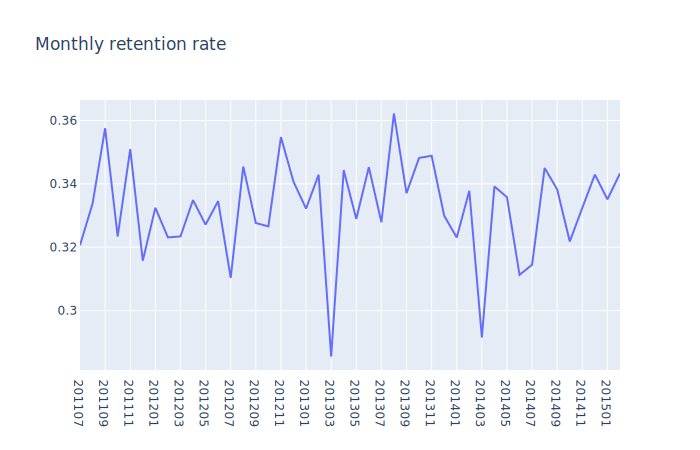

In [159]:
#deeps in monthly retention rate follow month with deep in monthly growth rate
plot_data = [
    go.Scatter(
        x=df_retention.query("TransYearMonth != 201105 and TransYearMonth != 201503")['TransYearMonth'],
        y=df_retention.query("TransYearMonth != 201105 and TransYearMonth != 201503")['RetentionRate'],
    ),
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Monthly retention rate'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
#pyoff.iplot(fig) 
fig.show("svg")